# 對 PTT 特斯拉 公司進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as font_manager
from wordcloud import WordCloud 
import jieba

## colab 使用套件

In [2]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集 PTT 特斯拉 2023/1/1~2024/4/30所有文章

In [69]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
2,2,2023-01-02,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
4,4,2023-01-02,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


### 2.2資料清理

In [70]:
clear_df = df.copy()

# 保留 'class' 列中值為 '性價比方面' 的行，改這裡
clear_df = clear_df[clear_df['class'] == '性價比方面']

#去除本次不會用到的欄位
drop_cols = [ 'sentence', 'LLM','sentiment']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,system_id,artDate,artTitle,artContent,class,sentence
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,1,2023-01-01,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,性價比方面,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
4,4,2023-01-02,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,性價比方面,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...
7,7,2023-01-03,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,性價比方面,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...
10,10,2023-01-04,新聞和泰汽車連續年稱霸台灣車市銷售,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...,性價比方面,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...
...,...,...,...,...,...,...
1574,1574,2024-04-29,討論這感覺已經不對,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...,性價比方面,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...
1579,1579,2024-04-30,新聞特斯拉全新入門電動車準備量產,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...,性價比方面,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...
1580,1580,2024-04-30,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,性價比方面,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...
1583,1583,2024-04-30,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,性價比方面,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...


斷句

In [71]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,system_id,artDate,artTitle,artContent,class,sentence
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,1,2023-01-01,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,性價比方面,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,4,2023-01-02,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,性價比方面,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...
3,7,2023-01-03,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,性價比方面,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...
4,10,2023-01-04,新聞和泰汽車連續年稱霸台灣車市銷售,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...,性價比方面,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...
...,...,...,...,...,...,...
563,1574,2024-04-29,討論這感覺已經不對,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...,性價比方面,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...
564,1579,2024-04-30,新聞特斯拉全新入門電動車準備量產,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...,性價比方面,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...
565,1580,2024-04-30,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,性價比方面,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...
566,1583,2024-04-30,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,性價比方面,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...


In [72]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from d:\114 NSYSU MIS\SMA_project\王唯宇\dict\dict.txt ...
Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u1731f4a1680978ab62dcf14bb5eb0f0d.cache
Loading model cost 0.971 seconds.
Prefix dict has been built successfully.


In [73]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,system_id,artDate,artTitle,artContent,class,sentence
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,1,2023-01-01,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,性價比方面,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,4,2023-01-02,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,性價比方面,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...
3,7,2023-01-03,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,性價比方面,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...
4,10,2023-01-04,新聞和泰汽車連續年稱霸台灣車市銷售,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...,性價比方面,笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...
...,...,...,...,...,...,...
563,1574,2024-04-29,討論這感覺已經不對,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...,性價比方面,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...
564,1579,2024-04-30,新聞特斯拉全新入門電動車準備量產,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...,性價比方面,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...
565,1580,2024-04-30,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,性價比方面,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...
566,1583,2024-04-30,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,性價比方面,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...


### 2.3 文章斷詞

In [74]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,system_id,artDate,artTitle,artContent,class,word
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,官網
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,特斯拉
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,二手車
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,很多
...,...,...,...,...,...,...
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,喜歡
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,飆車
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,不要
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,覺得


移除停用字

In [75]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["特斯拉", "Tesla", "馬斯克", "Elon", "Musk", "馬斯克的", "Tesla的", "Elon Musk", "Model", "S", "X", "3", "Y", 
    "電動車", "汽車", "車型", "自駕", "電池", "充電", "增程", "續航", "汽車公司", "電動", "技術", "設計", 
    "美國", "發表", "技術", "開發", "推出", "計劃", "概念", "未來", "汽車市場", "車廠", "新車", "車款", 
    "能源", "產能", "工廠", "製造", "交車", "零件", "新技術", "儲能", "工藝", "馬力", "加速", "性能", 
    "速度", "安全", "軟件", "硬件", "市場份額", "市場需求", "銷售", "推廣", "經營", "競爭", "進軍", 
    "行業", "產業", "趨勢", "領導", "品牌", "知名", "電動車市場", "充電站", "充電樁", "自動駕駛", 
    "市場定位", "科技公司", "財務", "股東", "投資者", "財報", "報表", "盈利", "損失", "業績", "資產", 
    "負債", "盈利預測", "股東大會", "董事會", "股價波動", "股市", "股票交易", "上市公司", "股票市場", 
    "融資", "併購", "合作", "合作夥伴", "生產線", "產能擴充", "研發", "新技術研發", "技術突破", 
    "行業標準", "生態系統", "新能源", "智能駕駛", "自動泊車", "智能網聯", "新能源車", "能源管理"]
stopwords.extend(stopwords_manual)

In [76]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,system_id,artDate,artTitle,artContent,class,word
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,官網
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,二手車
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,三方
0,0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,平台
...,...,...,...,...,...,...
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,不夠
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,必要
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,預算
567,1584,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,喜歡


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [77]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [78]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [79]:
ptt_liwc_df = pd.merge(noStop_df[["artDate", "artTitle", "artContent","class","word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artTitle,artContent,class,word,sentiments
0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦,affect
1,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,八卦,negative
2,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,官網,NaN
3,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,二手車,NaN
4,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,性價比方面,三方,NaN
...,...,...,...,...,...,...
55674,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,必要,NaN
55675,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,預算,NaN
55676,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,喜歡,affect
55677,2024-04-30,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,性價比方面,喜歡,positive


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [80]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-01-01,negative,4
4,2023-01-01,positive,1
6,2023-01-02,negative,2
8,2023-01-03,negative,2
9,2023-01-03,positive,3
...,...,...,...
944,2024-04-27,positive,20
943,2024-04-27,negative,14
947,2024-04-29,positive,2
949,2024-04-30,negative,2


```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


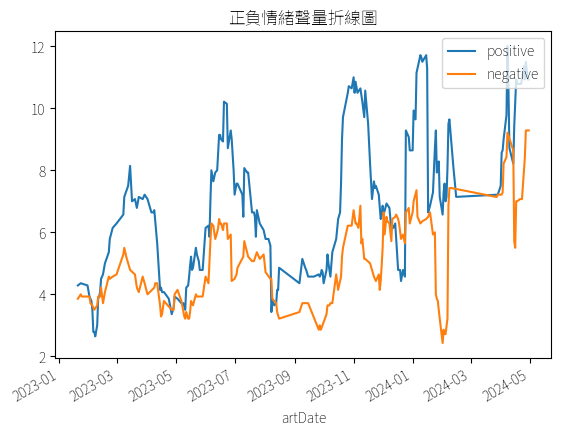

In [81]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，是個氣氛和諧的討論版。

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [82]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,0.800000
4,2023-01-01,positive,1,0.200000
6,2023-01-02,negative,2,1.000000
8,2023-01-03,negative,2,0.400000
9,2023-01-03,positive,3,0.600000
...,...,...,...,...
944,2024-04-27,positive,20,0.588235
943,2024-04-27,negative,14,0.411765
947,2024-04-29,positive,2,1.000000
949,2024-04-30,negative,2,0.142857


In [83]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

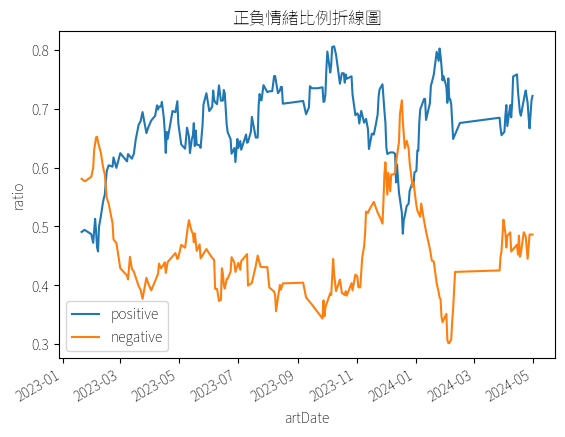

In [84]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 正負向情緒分數折線圖

In [85]:
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,0.800000
4,2023-01-01,positive,1,0.200000
6,2023-01-02,negative,2,1.000000
8,2023-01-03,negative,2,0.400000
9,2023-01-03,positive,3,0.600000
...,...,...,...,...
944,2024-04-27,positive,20,0.588235
943,2024-04-27,negative,14,0.411765
947,2024-04-29,positive,2,1.000000
949,2024-04-30,negative,2,0.142857


In [86]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2023-01-01,4,1
1,2023-01-02,2,0
2,2023-01-03,2,3
3,2023-01-04,1,7
4,2023-01-06,4,3


In [87]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-01-01,4,1,-3
1,2023-01-02,2,0,-2
2,2023-01-03,2,3,1
3,2023-01-04,1,7,6
4,2023-01-06,4,3,-1


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

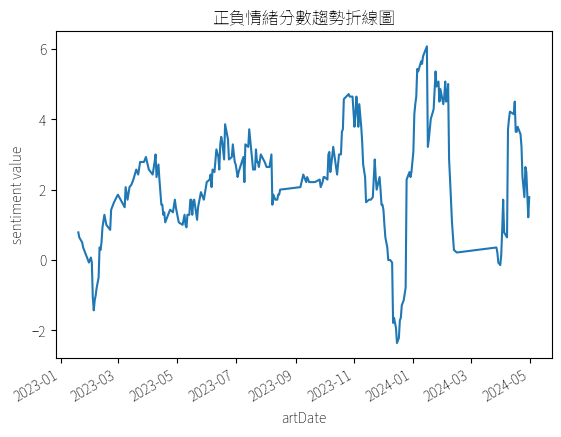

In [88]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 情緒代表字

In [89]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
211,問題,negative,185
210,問題,affect,185
879,豪華,positive,55
878,豪華,affect,55
98,優勢,affect,52
...,...,...,...
656,無用,negative,1
655,無用,affect,1
236,嚴厲,anger,1
237,嚴厲,negative,1


In [90]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
879,豪華,positive,55
99,優勢,positive,52
101,優惠,positive,47
219,喜歡,positive,44
932,重要,positive,42
850,解決,positive,41
30,不錯,positive,38
764,簡單,positive,38
315,容易,positive,34
567,朋友,positive,32


In [91]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
211,問題,negative,185
944,降低,negative,51
982,驚人,negative,27
243,嚴重,negative,25
260,壓力,negative,23
788,缺點,negative,23
510,擔心,negative,22
167,反對,negative,21
27,不足,negative,19
842,虧損,negative,19


C:\Users\hands\AppData\Local\Temp\ipykernel_10920\2349181045.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_10920\2349181045.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

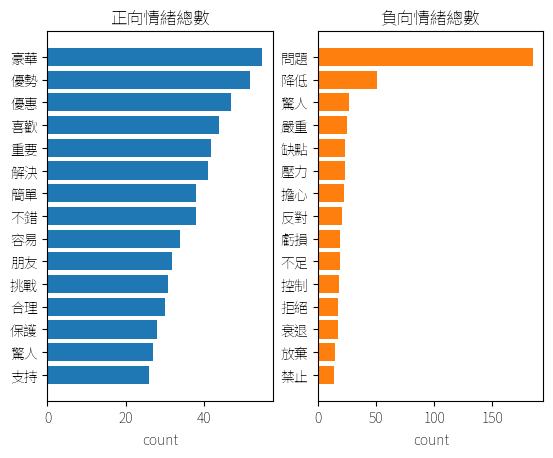

In [92]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

In [93]:
filtered_df = sent_df[sent_df['sentence'].str.contains('挑戰', na=False)]
filtered_df.head()

,system_id,artDate,artTitle,artContent,class,sentence
36,66,2023-01-20,新聞出師不利豐田想提高電動車,出師不利豐田想提高電動車銷量遇上前所未見的挑戰經濟日報編譯季晶晶綜合外電金融時報報導豐田汽車...,性價比方面,出師不利豐田想提高電動車銷量遇上前所未見的挑戰經濟日報編譯季晶晶綜合外電金融時報報導豐田汽車...
65,148,2023-02-15,新聞年全球電動車電池裝機量將達,原文連結原文內容根據韓國研究機構最新公佈的資料就顯示年全球電動車包括純電動車插電式混合動力車...,性價比方面,原文連結原文內容根據韓國研究機構最新公佈的資料就顯示年全球電動車包括純電動車插電式混合動力車...
67,168,2023-02-17,新聞曾被認為可挑戰特斯拉的改變戰略,曾被認為可挑戰特斯拉的改變戰略往電動自行車市場前進原文連結原文內容執行長在年月日的會議上告訴...,性價比方面,曾被認為可挑戰特斯拉的改變戰略往電動自行車市場前進原文連結原文內容執行長在年月日的會議上告訴...
70,176,2023-02-21,新聞電動車正進入快速成長期傳統車廠能否趕,電動車正進入快速成長期傳統車廠能否趕上特斯拉仍要等幾年才知道原文連結原文內容根據發布的一份關...,性價比方面,電動車正進入快速成長期傳統車廠能否趕上特斯拉仍要等幾年才知道原文連結原文內容根據發布的一份關...
72,183,2023-02-22,新聞年度十大車款油電車占半,原文連結原文內容經濟日報編譯陳律安綜合外電儘管未來將是電動車的天下但根據美國權威消費品評測雜...,性價比方面,原文連結原文內容經濟日報編譯陳律安綜合外電儘管未來將是電動車的天下但根據美國權威消費品評測雜...


In [94]:
# 設定要移除的字詞列表
words_to_remove = ['問題', '控制', '擔心', '錯過', '隨便', '強烈', '負擔', '口吃', '挑剔', '壓力', '邪惡', '禁止',
                   '挑戰', '謝謝', '智能', '智慧']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[[ "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artDate,artTitle,artContent,word,sentiments
0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦,affect
1,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦,negative
2,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,官網,NaN
3,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,二手車,NaN
4,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,三方,NaN


C:\Users\hands\AppData\Local\Temp\ipykernel_10920\1871799801.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_10920\1871799801.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

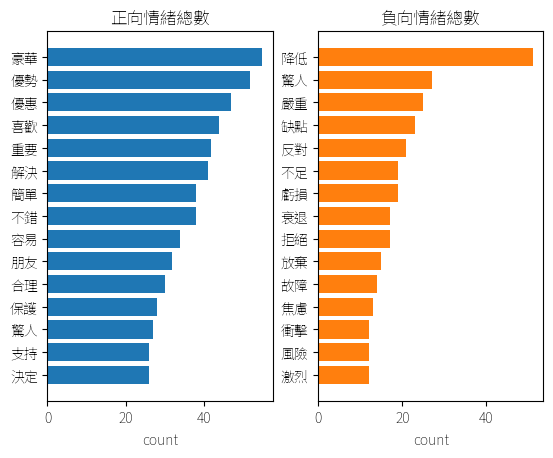

In [95]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

### 3.6 文章為單位的情緒分析

In [96]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["system_id", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

KeyError: 'system_id'

In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0


In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0,0.0
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0,3.0
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0,0.0
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0,-3.0


In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0,3.0,正向
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0,0.0,負向
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0,-3.0,負向
...,...,...,...,...,...,...,...,...,...
2278,https://www.ptt.cc/bbs/Stock/M.1710830890.A.CE...,12.0,3.0,3.0,11.0,4.0,0.0,-7.0,負向
2279,https://www.ptt.cc/bbs/Stock/M.1710843746.A.03...,2.0,0.0,0.0,1.0,0.0,0.0,-1.0,負向
2280,https://www.ptt.cc/bbs/Stock/M.1710851717.A.B6...,26.0,0.0,3.0,7.0,19.0,0.0,12.0,正向
2281,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向


In [ ]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,ATF91,Stock,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""hebeisme5566...",42.77.223.199,2023-03-21 02:21:44,ptt,負向
1,2,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20,black1x2y3z,Stock,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\r\n原文連結：\r\nhttps...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""maxdi"", ""cmt...",140.121.145.184,2023-03-21 02:21:44,ptt,正向
2,3,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20,Timzy,Stock,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxcv91039"", ...",223.141.185.139,2023-03-21 02:21:49,ptt,負向
3,4,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,[情報]0320上市外資買賣超排行,2023-03-20,saber50116,Stock,1. 標題：外資買賣超排行\r\n\r\n2. 來源：台灣證交所\r\n\r\n3. 網址：...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""powerkshs"", ...",111.255.56.173,2023-03-21 02:21:49,ptt,正向
4,5,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,[情報]6667信紘科111年5.11股利4.24,2023-03-20,a0808996,Stock,https://mops.twse.com.tw/mops/web/t146sb05\r\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""PeaceBoy"", ""...",123.194.132.40,2023-03-21 02:21:53,ptt,負向
...,...,...,...,...,...,...,...,...,...,...,...,...
2770,2771,https://www.ptt.cc/bbs/Stock/M.1710843746.A.03...,[標的]ADM.US,2024-03-19,yamakazi,Stock,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""gs13010"", ""c...",1.200.104.88,2024-03-20 02:05:23,ptt,負向
2771,2772,https://www.ptt.cc/bbs/Stock/M.1710851717.A.B6...,[新聞]賴清德向竹科半導體業掛保證維持兩岸和,2024-03-19,humbler,Stock,原文標題：\r\n賴清德向竹科半導體業掛保證 維持兩岸和平「水電不用擔心」\r\n\r\n原...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""nvlsvee"", ""c...",111.251.205.175,2024-03-20 02:05:27,ptt,正向
2772,2773,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,steward135,Stock,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hong92"", ""cm...",36.224.121.61,2024-03-20 02:05:31,ptt,NaN
2773,2774,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,[情報]0319上市櫃外資投信買超金額排行,2024-03-19,steveisaman,Stock,外資\r\n\r\n排行 股票名稱 百萬 收盤價 漲跌\r\n\r\n1 ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fernmmm"", ""c...",36.234.75.22,2024-03-20 02:05:31,ptt,正向


In [ ]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2023-03-20,正向,3
1,2023-03-20,負向,6
2,2023-03-21,正向,11
3,2023-03-21,負向,3
4,2023-03-22,正向,10
...,...,...,...
602,2024-03-17,負向,2
603,2024-03-18,正向,10
604,2024-03-18,負向,8
605,2024-03-19,正向,3


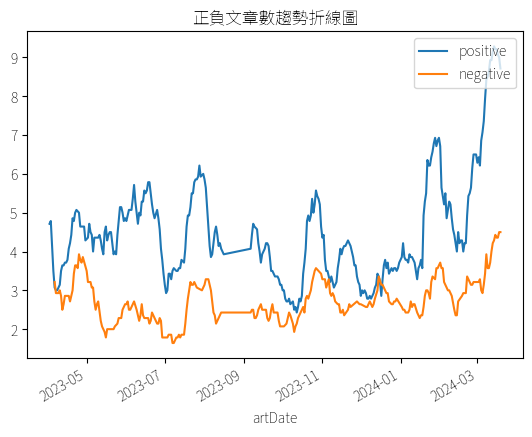

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

大部分文章都被歸類在正向文章，股票台積電版討論內容大多偏正面

### 3.7 情緒代表字

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
1271,獲利,positive,608
383,問題,affect,562
384,問題,negative,562
992,智慧,affect,384
993,智慧,positive,384
...,...,...,...
1348,眼淚,negative,1
1349,眼淚,sad,1
1350,眼花撩亂,affect,1
1351,眼花撩亂,negative,1


In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
1271,獲利,positive,608
993,智慧,positive,384
1723,重要,positive,334
1391,突破,positive,260
332,受惠,positive,236
608,希望,positive,235
1609,謝謝,positive,206
995,智能,positive,192
1783,領先,positive,179
679,復甦,positive,177


In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
384,問題,negative,562
1564,衰退,negative,316
1791,風險,negative,295
460,壓力,negative,284
1553,虧損,negative,248
1656,跌停,negative,199
1747,降低,negative,136
1657,跌破,negative,132
937,擔心,negative,116
99,低迷,negative,88


C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\1734313141.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\1734313141.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

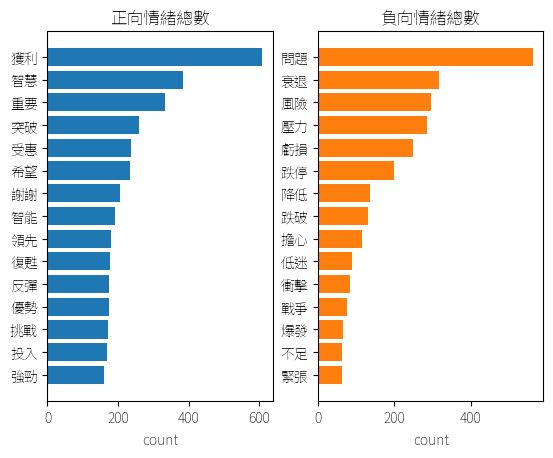

In [ ]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 檢查情緒詞是否符合本文本

In [ ]:
filtered_df = sent_df[sent_df['sentence'].str.contains('問題', na=False)]
filtered_df.head()

,system_id,artDate,artTitle,artContent,class,sentence
2,4,2023-01-02,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,性價比方面,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...
3,7,2023-01-03,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,性價比方面,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...
6,14,2023-01-06,新聞特斯拉跳水大降價台灣大陸,原文連結原文內容特斯拉跳水大降價台灣大陸價差萬創新高記者鄧光惟綜合報導特斯拉要跟中國大陸國產...,性價比方面,原文連結原文內容特斯拉跳水大降價台灣大陸價差萬創新高記者鄧光惟綜合報導特斯拉要跟中國大陸國產...
9,19,2023-01-07,新聞全年銷量稱霸澳洲中型房車類別,原文連結原文內容全年銷量稱霸澳洲中型房車類別終結長達年的霸主地位純電休旅是特斯拉當前最夯的明...,性價比方面,原文連結原文內容全年銷量稱霸澳洲中型房車類別終結長達年的霸主地位純電休旅是特斯拉當前最夯的明...
16,32,2023-01-13,問題該選誰,目前兩台車在猶豫有幾個點在猶豫售價約萬售價約萬主要疑問家裡透天可以充電這樣在外的超充會有問題...,性價比方面,目前兩台車在猶豫有幾個點在猶豫售價約萬售價約萬主要疑問家裡透天可以充電這樣在外的超充會有問題...


In [ ]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來自美國國家交通安全管理局與已發表的報告顯示美國有至少款汽車被召回其中福特成為在美國召回次數與召回車輛最多的車廠遙遙領先其他汽車品牌這份資料顯示福特在年有多達次的召回總召回量來到萬輛最主要的召回原因是車輛停放時可能會滑動溜走所致有多達約萬輛車集團則有次共萬輛有約萬輛是因為胎壓偵測故障無法告知駕駛所召回第三至第五名則分別為集團的次賓士的次的次而特斯拉則為次影響萬輛車最大的召回原因是窗戶會夾傷駕駛或乘客心得說明字以上銷售量還沒出來以來看福特是賣第二多的沒錯但上課也領先的太誇張了吧特斯拉只有次但量蠻多感覺都是大條的問題銷售第一的豐田榜上無名
原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布年第四季的生產交付結果全年交車成績單也一併揭曉去年第四季特斯拉生產交付數據再創新高單季全球交車總量超過萬輛也讓特斯拉正式成為百萬輛規模的車廠年全球交車總量突破萬輛大關爆量輛台灣特斯拉第四季掛牌再創新高超人氣純電休旅一月中旬開放試駕原文網址根據特斯拉官方公開的數據年第四季旗下全車系合計生產萬輛並在全球市場交付萬輛這兩項數據都是特斯拉的歷史新紀錄輕鬆超越第三季的萬輛總生產量和萬輛的總交付量全球交車破萬輛總產量超過萬輛特斯拉年第三季觸底反彈再創新紀錄原文網址加上第四季的生產交付數據之後讓特斯拉的全年生產量從年的萬躍升到萬輛至於全年交付量則從年的萬輛衝高到萬輛若年第二季沒有受到上海工廠一度停工的影響或許特斯拉去年的總生產量能夠更接近先前馬斯克預期的萬輛關卡光看年第四季的話新款和共計生產輛交付輛至於則是共計生產輛交付輛以年全年的數據來看新款和共計生產輛交付輛而則是共計生產輛交付輛在公開年第四季以及全年生產交付數據的同時特斯拉也一併預告將於美國時間年月日舉辦年第四季和全年的財報會議屆時特斯拉有望對外公開下一座超級工廠的設置地點到底會在韓國印尼加拿大還是墨西哥到時應該就會有正式答案心得說明字以上當初兩年前的規劃是每年成長因為各種缺料跟運送還有生產問題每年第一季股東會都有下修實際目標不過交車量還是從萬萬到萬不斷成長除了這樣的成長幅度很驚人之外更重要的是特斯拉依舊處於供不應求的狀態
原文連結原文內容特斯拉跳水大降價台灣大陸價差萬創新高記者鄧光惟綜合報導特斯拉要跟中國大陸國產

#### 重新計算情緒

In [ ]:
# 設定要移除的字詞列表
words_to_remove = ['問題', '低迷','缺點']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[[ "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artDate,artTitle,artContent,word,sentiments
0,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦,affect
1,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦,negative
2,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,官網,NaN
3,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,二手車,NaN
4,2023-01-01,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,三方,NaN


C:\Users\hands\AppData\Local\Temp\ipykernel_10920\1871799801.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_10920\1871799801.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

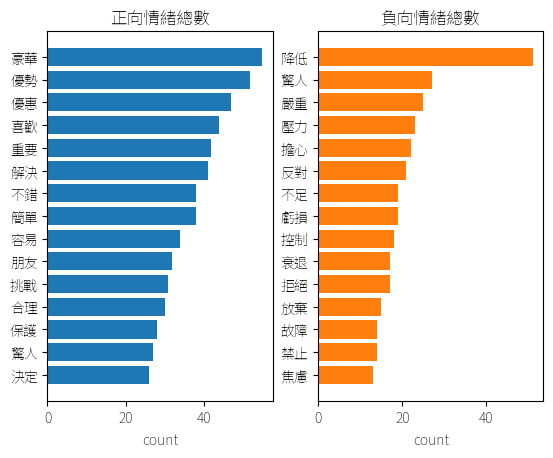

In [ ]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

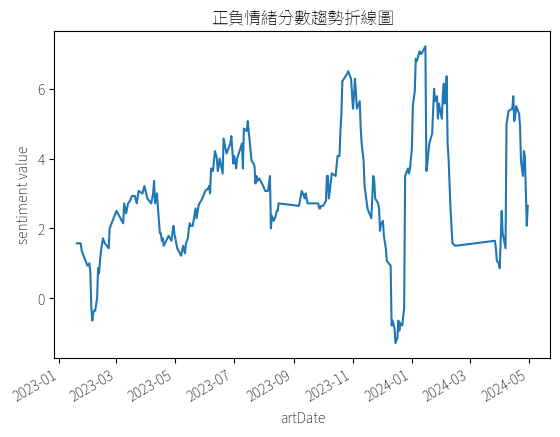

In [ ]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 2023-10-15 ~2023-11-01 文字雲
2023-10-15 ~2023-11-01 在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [ ]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

NameError: name 'ptt_sentiment_value_by_article' is not defined

In [ ]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的 富時不動產\r例 TW 台積電\r 分類討論\r\r 分析正文\r\r這隻已經超過...,負向
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,股價卻沒有急速下跌,負向
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,是每天凌遲你那種小小跌,負向
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,明\r天除息,負向
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,整年殖利率可能有趴以上,負向


In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
201090,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,affect,負向
201091,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,negative,負向
201092,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,anger,負向
201093,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,廣告,NaN,負向
201094,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,平台,NaN,負向
...,...,...,...,...,...,...,...
219423,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,股利,NaN,負向
219424,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,零用錢,NaN,負向
219425,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,乖乖,NaN,負向
219426,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,爆發,affect,負向


In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
1729,美債,46
171,下跌,34
1850,衝突,33
1974,賣超,32
1731,美國,31
...,...,...
1365,殞落,1
234,之稱,1
706,士開,1
1362,歸來,1


(-0.5, 399.5, 199.5, -0.5)

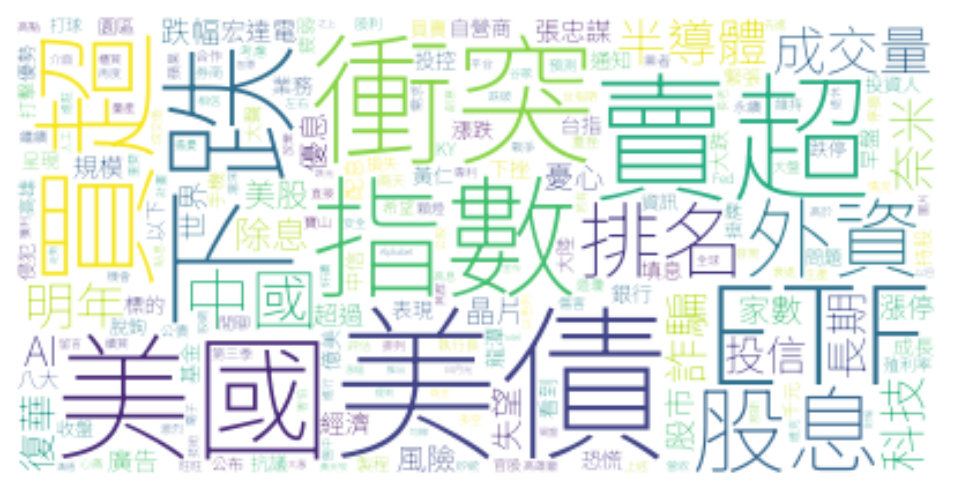

In [ ]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「美債」、「AI」、「賣超」、「衝突」、「下跌」的關鍵字，可能是在說明美債導致台積電下跌

(-0.5, 399.5, 199.5, -0.5)

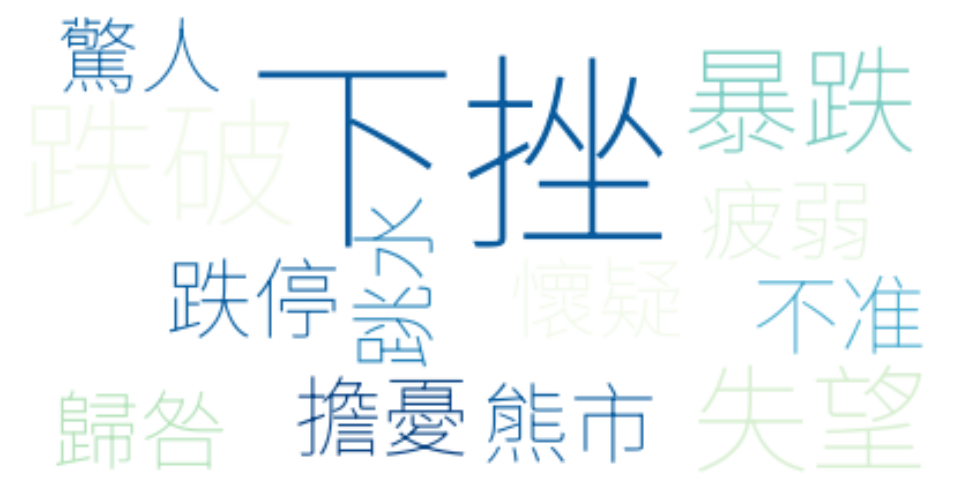

In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('美債')) & ( # 內文包含美債
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「下挫」去查看原文內容

In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('美債')) & (
    sent_df['sentence'].str.contains('下挫')) # 包含「下挫」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
44922,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,引發投資人擔憂聯準會Fed可能將利率維持在高檔更久,負向
44923,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,並可能再度升息,負向
44924,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r同\r時,負向
44925,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r道瓊工業指數早盤跌近百點或,負向
44926,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,標普指數和那斯達克綜合指數各跌和,負向
44927,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r費城半導體指數下挫,負向
44928,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,台積電ADR也跌,負向
44929,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r\r美國月整體零售銷售月增,負向
44930,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,遠高於預估的增幅,負向
44931,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,扣除汽車之後的核心銷售額比\r月增加,負向


文章中提到了台股重挫，道瓊指數下跌